In [25]:
# import modules
import os
from nilearn import image as nimg
from nilearn import plotting as nplot
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import bids
import pandas as pd

In [26]:
# define working dir and data saving dir
fmriprep_dir ='/Users/wang/Desktop/Research_projects/BBSC/Functional/Prep/fMRIprep'
data_save_dir = '/Users/wang/Desktop/Research_projects/BBSC/Functional/Parcellation/data/cleaned_data/'
os.chdir(fmriprep_dir)
#os.mkdir(data_save_dir)

In [27]:
# creat a layout with the bids module
layout = bids.BIDSLayout(fmriprep_dir,validate=False,
                        config=['bids','derivatives'])

In [28]:
sub_list = layout.get_subjects()
sub_list.sort()

In [29]:
# to test we have the right numbers
for subi, subname in enumerate(sub_list):
    print (subi, subname)


0 01
1 02
2 03


In [30]:
 # to pull all the func, mask, and confound files from a subject
    func_files = layout.get(subject='01',
                        datatype='func', task='rest',
                        desc='preproc',
                        space='MNI152NLin6Asym',
                        extension='nii.gz',
                       return_type='file')

    mask_files = layout.get(subject='01',
                        datatype='func', task='rest',
                        desc='brain',
                        suffix='mask',
                        space='MNI152NLin6Asym',
                        extension="nii.gz",
                       return_type='file')
    confound_files = layout.get(subject='01',
                            datatype='func', task='rest',
                            desc='confounds',
                           extension="tsv",
                           return_type='file')

In [31]:
func_files


['/Users/wang/Desktop/Research_projects/BBSC/Functional/Prep/fMRIprep/sub-01/ses-01/func/sub-1_ses-1_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz',
 '/Users/wang/Desktop/Research_projects/BBSC/Functional/Prep/fMRIprep/sub-01/ses-02/func/sub-1_ses-2_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz',
 '/Users/wang/Desktop/Research_projects/BBSC/Functional/Prep/fMRIprep/sub-01/ses-03/func/sub-1_ses-3_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz',
 '/Users/wang/Desktop/Research_projects/BBSC/Functional/Prep/fMRIprep/sub-01/ses-04/func/sub-1_ses-4_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz',
 '/Users/wang/Desktop/Research_projects/BBSC/Functional/Prep/fMRIprep/sub-01/ses-05/func/sub-1_ses-5_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz',
 '/Users/wang/Desktop/Research_projects/BBSC/Functional/Prep/fMRIprep/sub-01/ses-06/func/sub-1_ses-6_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz',
 '/U

In [32]:
        func_file = func_files[0]
        mask_file = mask_files[0]
        confound_file = confound_files[0]


In [33]:
func_file

'/Users/wang/Desktop/Research_projects/BBSC/Functional/Prep/fMRIprep/sub-01/ses-01/func/sub-1_ses-1_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz'

In [37]:
# load the confound file and extract the 18 confounds we will use to clean the data
confound_df = pd.read_csv(confound_file, delimiter='\t')
confound_vars = ['trans_x','trans_y','trans_z',
                        'rot_x','rot_y','rot_z',
                        'global_signal',
                        'csf', 'white_matter']


derivative_columns = ['{}_derivative1'.format(c) for c
                            in confound_vars]
final_confounds = confound_vars + derivative_columns
confound_df = confound_df[final_confounds]

In [38]:
# drop the first 4 datapoints 
raw_func_img = nimg.load_img(func_file)
raw_func_img.shape
func_img = raw_func_img.slicer[:,:,:,4:]
func_img.shape

(91, 109, 91, 346)

In [39]:
# drop the first 4 datapoints in confounds
drop_confound_df = confound_df.loc[4:]
confounds_matrix = drop_confound_df.values
confounds_matrix.shape

(346, 18)

In [40]:
# filter the data 
high_pass= 0.009
low_pass = 0.08
t_r = 2.05

In [41]:
# clean the data with the parameters
clean_img = nimg.clean_img(func_img,confounds=confounds_matrix,detrend=True,standardize=True,
                         low_pass=low_pass,high_pass=high_pass,t_r=t_r, mask_img=mask_file)

In [ ]:
# to valide the file path and file names we would like to save
subi=1
sesi=1
clean_img.to_filename('./sub-%s/ses-%s/func/sub-%s_ses-%s_task-rest_\
space-MNI152NLin6Asym_res-2_desc-preproc_bold_clean_normalized.nii.gz'\
      % (str(subi).zfill(2),str(sesi).zfill(2),str(subi),str(sesi)))

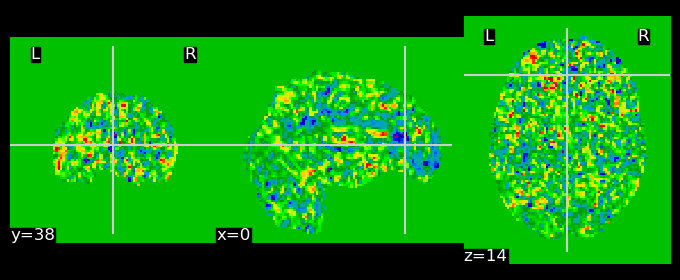

In [42]:
nplot.plot_epi(clean_img.slicer[:,:,:,50])

In [43]:
# plot the raw the data 
data2plot = raw_func_img.slicer[59:60,45:46,30:31,:].get_data()
data2plot = data2plot.flatten() # like the squeez function in matlab
data2plot.shape

/tmp/ipykernel_97817/2230594395.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data2plot = raw_func_img.slicer[59:60,45:46,30:31,:].get_data()


(350,)

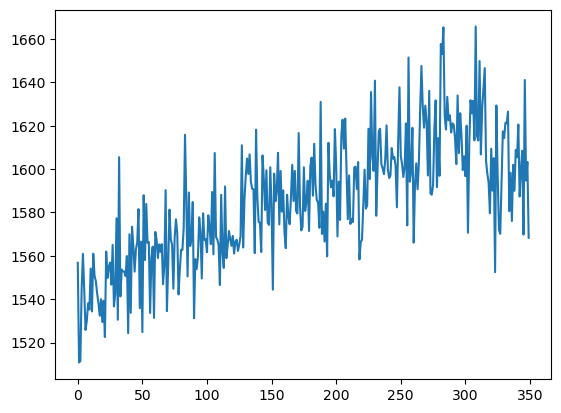

In [44]:
plt.plot(data2plot)

In [45]:
# plot the cleaned data
data2plot = clean_img.slicer[59:60,45:46,30:31,:].get_data()
data2plot = data2plot.flatten()
data2plot.shape

/tmp/ipykernel_97817/3164662191.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data2plot = clean_img.slicer[59:60,45:46,30:31,:].get_data()


(346,)

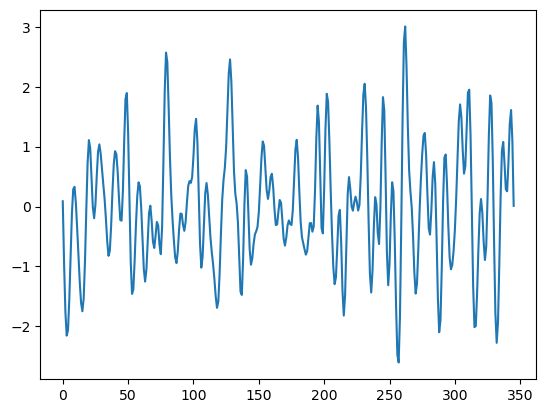

In [46]:
plt.plot(data2plot)